#Chapter 4 회귀와 예측

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/New Hobby/데이터 과학을 위한 통계/practicalstatisticsfordatascientists/python

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/New Hobby/데이터 과학을 위한 통계/practicalstatisticsfordatascientists/python


In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

!pip install pygam
from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

!pip install dmba
from dmba import stepwise_selection
from dmba import AIC_score

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 27.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 22.6 MB/s eta 0:00:00
Colab environment detected.


In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [4]:
LUNG_CSV = DATA / 'LungDisease.csv'
HOUSE_CSV = DATA / 'house_sales.csv'

#4.1 단순선형회귀

##용어정리
- 응답변수(반응변수) : 예측하고자하는 변수
- 독립변수 : 응답치를 예측하기 위해 사용되는 변수
- 레코드 : 한 특정 경우에 대한 입력과 출력을 담고 있는 벡터
- 절편 : 회귀직선의 절편
- 회귀계수 : 회귀 직선의 기울기
- 적합값 : 회귀선으로부터 얻은 추정치 $ \hat{Y} $
- 잔차 : 관측값과 적합값의 차이
- 최소제곱 : 잔차와 제곱합을 최소화하여 회귀를 피팅하는 방법

In [5]:
lung = pd.read_csv(LUNG_CSV)

- 회귀식

$Y = b_0 + b_1 X$

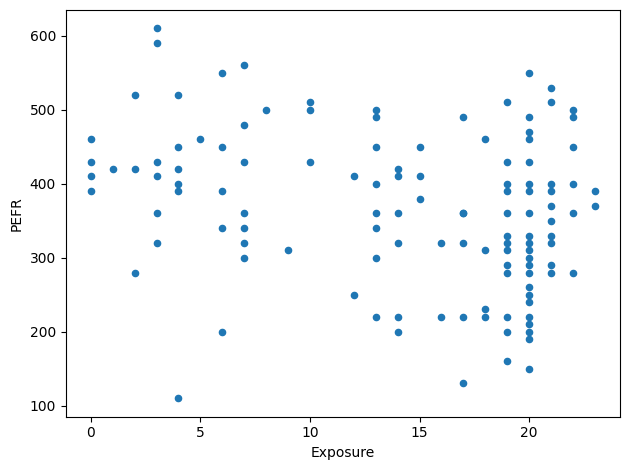

In [6]:
lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

In [7]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_:.3f}')
print(f'Coefficient Exposure: {model.coef_[0]:.3f}')

Intercept: 424.583
Coefficient Exposure: -4.185


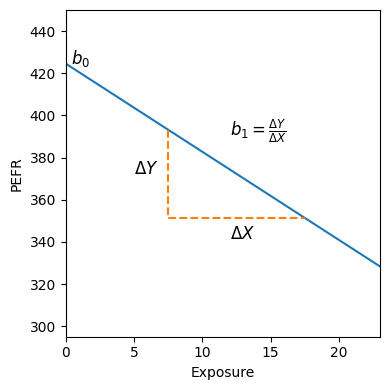

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel('Exposure')
ax.set_ylabel('PEFR')
ax.plot((0, 23), model.predict(pd.DataFrame({'Exposure': [0, 23]})))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x = pd.DataFrame({'Exposure': [7.5,17.5]})
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

$e_i$ : 잔차(예측오차) ; $Y_i$ : 실제값 ; $\hat{Y_i}$ : 적합값(예측값)


- $Y_i = b_0 + b_1X_i + e_i$

- $\hat{Y_i} = \hat{b_0} + \hat{b_1}X_i$

- $\hat{e_i} = Y_i - \hat{Y_i}$

In [9]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

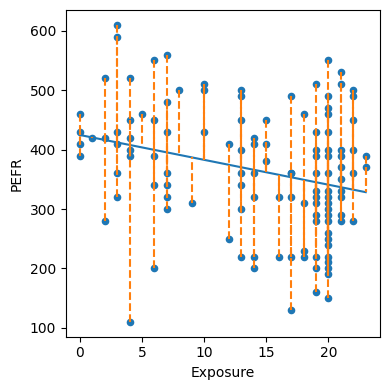

In [10]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted):
    ax.plot((x, x), (yactual, yfitted), '--', color='C1')

plt.tight_layout()
plt.show()

##주요개념
- 회귀방정식은 응답변수 $Y$와 예측변수 $X$간의 관계를 선형 함수로 모델링한다.
- 회귀모형은 적합값과 잔차, 즉 반응에 대한 예측과 그 예측 오차를 산출한다.
- 회귀모형은 일반적으로 최소제곱법을 이용해 피팅한다.
- 회귀는 예측과 설명 모두에 사용된다.

#4.2 다중선형회귀

$Y = b_0 + b_1X_1 + b_2X_2 + ... + b_pX_p + e$

> 더는 직선의 형태는 아니지만, 각 계수와 그 변수들 사잉의 관계는 여전히 선형이므로, 선형모형이다.

##용어정리
- 제곱근평균제곱오차(RMSE, root mean squared error) : 회귀 시 평균제곱오차의 제곱근. 회귀모형을 평가하는 데 가장 널리 사용되는 측정 지표이다.
- 잔차 표준오차(RSE, residual standard error) : 평균제곱오차와 동일하지만, 자유도에 따라 보정된 값
- R 제곱 : 0에서 1까지 모델에 의해 설명된 분산의 비율
- t 통계량 : 계수의 표준오차로 나눈 예측변수의 계수. 모델에서 변수의 중요도를 비교하는 기준이 된다.
- 가중회귀 : 다른 가중치를 가진 레코드들을 회귀하는 방법

In [11]:
# 킹 카운티 주택 정보 예제
house = pd.read_csv(HOUSE_CSV, sep='\t')

In [12]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
  print(f'{name} : {coef}')

Intercept: -521871.368
Coefficients:
SqFtTotLiving : 228.83060360240793
SqFtLot : -0.06046682065307607
Bathrooms : -19442.840398321066
Bedrooms : -47769.95518521438
BldgGrade : 106106.96307898081


$RMSE = \sqrt{\frac{\sum^n_{i=1} (y_i - \hat{y_i})^2}{n}}$

$RSE = \sqrt{\frac{\sum^n_{i=1} (y_i - \hat{y_i})^2}{(n-p-1)}}$

In [13]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

RMSE: 261220
r2: 0.5406


In [14]:
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        09:05:05   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694      0.000     221.189     236.472
SqFtLot          -0.0605      0.061     -0.988      0.323      -0.180       0.059
Bathrooms     -1.944e+04   3625.388     -5.363      0.000   -2.65e+04   -1.23e+04
Bedrooms      -4.777e+04   2489.732    -19.187      0.000   -5.27e+04   -4.29e+04
BldgGrade      1.061e+05   2396.445     44.277      0.000    1.01e+05    1.11e+05
const         -5.219e+05   1.57e+04    -33.342      0.000   -5.53e+05   -4.91e+05
==============================================================================
Omnibus:                    29676.557   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19390738.346
Skew:                           6.889   Prob(JB):                         0.00
Kurtosis:                     145.559   Cond. No.                     2.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

$R^2 = 1 - \frac{\sum^n_{i=1}(y_i - \hat{y_i})^2}{\sum^n_{i=1}(y_i - \bar{y})^2}$

$t_b = \frac{\hat{b}}{SE(\hat{b})}$

- k 다중 교차타당성 검사
1. 1/k의 데이터를 홀드아웃 샘플로 따로 떼어놓는다.
2. 남아 있는 데이터로 모델을 훈련시킨다.
3. 모델을 1/k 홀드아웃에 적용(점수를 매김)하고 필요한 모델 평가 지표를 기록한다.
4. 데이터의 첫번째 1/k을 복원하고 다음 1/k(앞에서 선택했던 레코드는 제외)을 따로 보관한다.
5. 2~3단계를 반복한다.
6. 모든 레코드가 홀드아웃 샘플로 사용될 때까지 반복한다.
7. 모델 평가 지표들을 평균과 같은 방식으로 결합한다.

In [15]:
#모형 선택 밑 단계적 회귀
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'BldgGrade', 'PropertyType',
              'NbrLivingUnits', 'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     2920.
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        09:05:05   Log-Likelihood:            -3.1398e+05
No. Observations:               22687   AIC:                         6.280e+05
Df Residuals:                   22675   BIC:                         6.281e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving                173.6652      4.115     42.203      0.000     165.600     181.731
SqFtLot                        0.1540      0.058      2.635      0.008       0.039       0.268
Bathrooms                   2.644e+04   3770.025      7.014      0.000    1.91e+04    3.38e+04
BldgGrade                   1.445e+05   2443.317     59.123      0.000     1.4e+05    1.49e+05
NbrLivingUnits             -1.861e+04   1.77e+04     -1.051      0.293   -5.33e+04    1.61e+04
SqFtFinBasement                1.7960      4.668      0.385      0.700      -7.354      10.946
YrBuilt                    -3612.3852     77.999    -46.313      0.000   -3765.268   -3459.502
YrRenovated                   -1.4700      3.964     -0.371      0.711      -9.239       6.299
NewConstruction             1888.9976   5994.059      0.315      0.753   -9859.770    1.36e+04
PropertyType_Single Family  3.626e+04   2.64e+04      1.376      0.169   -1.54e+04    8.79e+04
PropertyType_Townhouse      1.249e+05   2.72e+04      4.585      0.000    7.15e+04    1.78e+05
const                       6.132e+06   1.56e+05     39.180      0.000    5.82e+06    6.44e+06
==============================================================================
Omnibus:                    30935.649   Durbin-Watson:                   1.370
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         25571634.302
Skew:                           7.402   Prob(JB):                         0.00
Kurtosis:                     166.806   Cond. No.                     2.98e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* 변수를 추가할수록, 학습 데이터에 대해 항상 RMSE는 감소하고 R 제곱은 증가한다.

- 수정 R 제곱
$R^2_{adj} = 1 - (1-R^2)\frac{n-1}{n-P-1}$ (n : 레코드 수, P : 모델의 변수 개수)

* $AIC = 2P + nlog(RSS/n)$

In [17]:
# 사이킷런은 단계적 회귀를 구현해놓지 않았다. : dmba 패키지 이용
y = house[outcome]

def train_model(variables): #주어진 변수 집합에 대해 적합 모델을 반환하는 함수
  if len(variables) == 0:
    return None
  model = LinearRegression()
  model.fit(X[variables], y)
  return model

def score_model(model, variables): #주어진 모델과 변수 세트에 대한 점수를 반환하는 함수
  if len(variables) == 0:
    return AIC_score(y, [y.mean()] * len(y) , model, df=1)
  return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, verbose=True)

print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
  print(f' {name}: {coef}')

Variables: SqFtTotLiving, SqFtLot, Bathrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=628041.60, add PropertyType_Townhouse
Step: score=628002.07, add Bathrooms
Step: score=627990.29, add PropertyType_Single Family
Step: score=627985.58, add SqFtLot
Step: score=627985.58, unchanged None
Intercept: 6072447.537
Coefficients:
 SqFtTotLiving: 174.21911887125236
 BldgGrade: 144409.15253459566
 YrBuilt: -3602.596363603845
 PropertyType_Townhouse: 147615.8529306506
 Bathrooms: 25926.088340890892
 PropertyType_Single Family: 58336.29555144764
 SqFtLot: 0.1504962641338352


- 후진 제거 : 전체 모델부터 시작하여 별로 의미 없는 변수들을 연속적으로 삭제해나가는 것
- 전진 선택 : 상수 모델에서 시작하여 연속적으로 변수를 추가해나가는 것